# Colored Noise

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'

import arviz as az
import celerite2
from celerite2 import terms
from celerite2.theano import terms as theano_terms
import celerite2.theano
import h5py
import pymc3 as pm
import pymc3_ext as pmx
from scipy.interpolate import interp1d
from scipy.signal import welch, decimate
from scipy.signal.windows import tukey
import seaborn as sns
import stan_jupyter as stan
import theano.tensor as T

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

Populating the interactive namespace from numpy and matplotlib


## Some random notes from Lecture

Correlated Noise

In [2]:
Sigma = array([[2.0, sqrt(2)*sqrt(3)*0.9], [sqrt(2)*sqrt(3)*0.9, 3]])

xs = np.random.multivariate_normal(zeros(2), Sigma, size=1000)

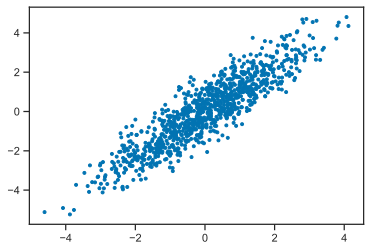

In [3]:
plot(xs[:,0], xs[:,1], '.')

Here we made a Gaussian process with kernel 
$$
k\left( x_i, x_j \right) = \sigma^2 \exp\left( -\frac{1}{2} \left(\frac{x_i - x_j}{\lambda} \right)^2 \right).
$$
For obvious reasons, this is called the "squared exponential kernel."  A good place to learn a lot about Gaussian processes, kernel functions, etc, etc, is {cite}`RasmussenWilliams`, which can be found online [here](http://www.gaussianprocess.org/gpml/chapters/).

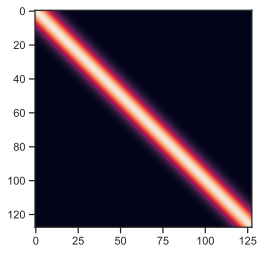

In [4]:
xs = linspace(-1, 1, 128)

sigma2 = 10.0
lambda2 = 0.01
def k(xi, xj):
    return sigma2*np.exp(-0.5*np.square(xi-xj)/lambda2)

Sigma = zeros((128,128))
for i in range(128):
    for j in range(128):
        Sigma[i,j] = k(xs[i], xs[j])

imshow(Sigma)

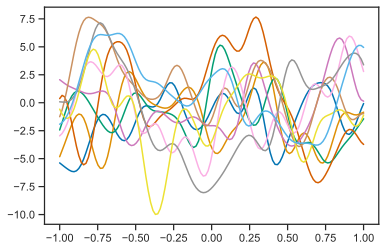

In [5]:
for i in range(10):
    plot(xs, np.random.multivariate_normal(zeros_like(xs), Sigma))

$$
\rho(\tau) = \sigma^2 \exp\left( -\frac{\left| \tau \right|}{\lambda} \right)
$$

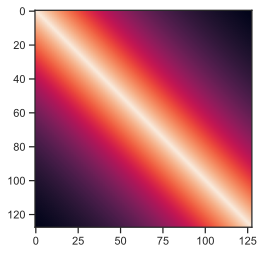

In [6]:
xs = linspace(-1, 1, 128)

sigma2 = 10.0
tau = 1.0
def k(xi, xj):
    return sigma2*np.exp(-np.abs(xi-xj)/tau)

Sigma = zeros((128,128))
for i in range(128):
    for j in range(128):
        Sigma[i,j] = k(xs[i], xs[j])

imshow(Sigma)

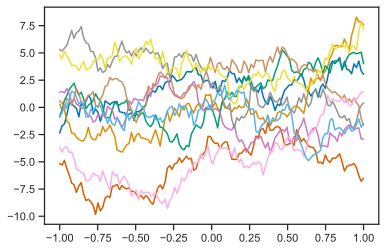

In [7]:
for i in range(10):
    plot(xs, np.random.multivariate_normal(zeros_like(xs), Sigma))

## An Example from LIGO

I downloaded the Hanford LIGO data for GW150914 from [GWOSC](https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3).  There are a number of different data products there, but I grabbed the 4 kHz sample rate, 32 second long segment surrounding this event.  I also grabbed the "parameter estimation" posterior samples from the same place.

In [3]:
with h5py.File('data/H-H1_GWOSC_4KHZ_R1-1126259447-32.hdf5', 'r') as f:
    strain = array(f['strain/Strain'])
    strain_start = array(f['meta/GPSstart'])[()]
    dt = 1.0 / 4096.0
    strain_times = linspace(0, (len(strain)-1)*dt, len(strain))

In [4]:
with h5py.File('data/GW150914_GWTC-1.hdf5', 'r') as f:
    postsamples = array(f['Overall_posterior'])
t_approx = 1126259462.422

Text(0, 0.5, '$h(t)$')

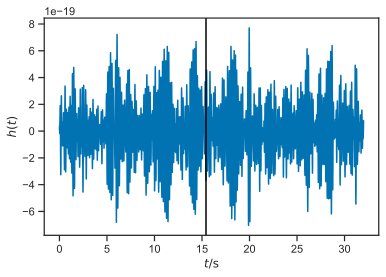

In [5]:
plot(strain_times, strain)
axvline(t_approx - strain_start, color='k')
xlabel(r'$t / \mathrm{s}$')
ylabel(r'$h(t)$')

We know the 150914 signal ends at low frequency (< 500 Hz), so we will decimate this data to 1024 sample rate (i.e. by a factor of 4):

In [6]:
lowpass_strain = decimate(strain, 4)
lowpass_strain_times = strain_times[::4]
lowpass_dt = dt*4

In [7]:
T = 0.5
seglen = int(round(T/lowpass_dt))
fs, psd = welch(lowpass_strain, fs=1/lowpass_dt, nperseg=seglen)

Text(0, 0.5, '$P(f) / \\mathrm{strain}^2 \\, \\mathrm{Hz}^{-1}$')

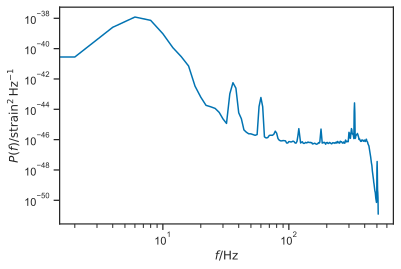

In [8]:
loglog(fs, psd)
xlabel(r'$f / \mathrm{Hz}$')
ylabel(r'$P(f) / \mathrm{strain}^2 \, \mathrm{Hz}^{-1}$')

Let's whiten the data: the PSD measures the density of the variance in frequency space, so the s.d. in a frequency bin is $\sqrt{P(f)*\delta f}$:

In [9]:
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    white_hf = hf / (np.sqrt(interp_psd(freqs) /dt/2.))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

In [10]:
white_strain = whiten(lowpass_strain, interp1d(fs, psd), lowpass_dt)

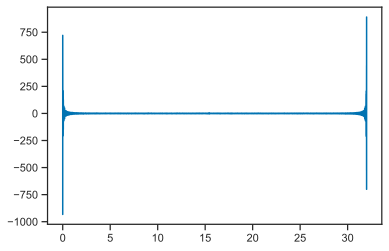

In [11]:
plot(lowpass_strain_times, white_strain)

Funky things happen at the end of the segment.  Why is that?  (Periodicity.)  It's better to whiten a *windowed* version of the data that enforces periodicity.  Here we use a Tukey window (which tapers off to zero on either end over one-second intervals):

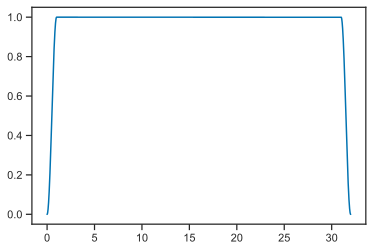

In [12]:
strain_window = tukey(len(lowpass_strain), alpha=2/32)
plot(lowpass_strain_times, strain_window)

In [13]:
white_strain = whiten(lowpass_strain*strain_window, interp1d(fs, psd), lowpass_dt)

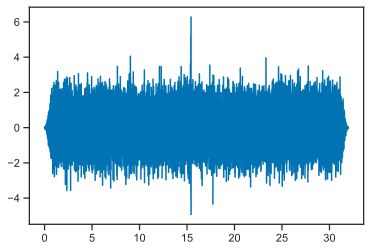

In [14]:
plot(lowpass_strain_times, white_strain)

And here's our merger:

Text(0, 0.5, '$h(t)$ (whitened)')

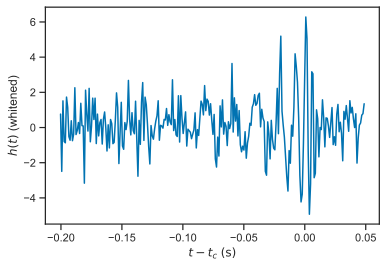

In [15]:
imerg = argmin(abs(lowpass_strain_times - (t_approx - strain_start)))
rng = range(int(round(imerg-0.2/lowpass_dt)),int(round(imerg+0.05/lowpass_dt)))
plot(lowpass_strain_times[rng]-(t_approx-strain_start), white_strain[rng])
xlabel(r'$t - t_c$ $(\mathrm{s})$')
ylabel(r'$h(t)$ (whitened)')

A good place to go for discussions like what we are about to have is the ["GW150914 basic physics" paper](https://arxiv.org/abs/1608.01940) {cite}`GW150914Basic`; for "real" post Newtonian expansions, see {cite}`Blanchet2014`.  The basic physics paper gives the evolution of the *inspiral* phase with time:
$$
\frac{1}{2\pi} \frac{\mathrm{d} \Phi}{\mathrm{d} t} = f_\mathrm{GW} = \frac{5^{3/8}}{\left( 8 \pi \right)} \left( \frac{G M_c}{c^3} \right)^{-5/8} \left( t - t_c \right)^{-3/8}
$$

/var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/ipykernel_6604/3102124229.py:2: RuntimeWarning: invalid value encountered in power
  fs = (1100.0*(4.9e-6*20.0)**(5.0/3.0)*(-ts))**(-3.0/8.0)


Text(0, 0.5, '$f_{\\mathrm{GW}} / \\mathrm{Hz}$')

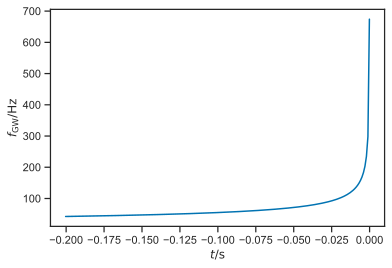

In [24]:
ts = lowpass_strain_times[rng]-(t_approx-strain_start)
fs = (1100.0*(4.9e-6*20.0)**(5.0/3.0)*(-ts))**(-3.0/8.0)
plot(ts, fs)
xlabel(r'$t / \mathrm{s}$')
ylabel(r'$f_{\mathrm{GW}} / \mathrm{Hz}$')

Because the inspiral frequency reaches $\infty$ in finite time, we will have to do something.  Here's something:
 * To truncate the frequency at some $f_\mathrm{max}$ (a parameter).
 * To have an exponentially-damped amplitude decay once the frequency reaches $f_\mathrm{max}$.
 * To use a power-law amplitude with unknown index.

So
$$
h(t) = A_{100} \left( \frac{f(t)}{100 \, \mathrm{Hz}} \right)^\alpha \cos \left( \phi_0 + \Phi(t) \right) \frac{1}{1 + \exp\left( \frac{t - t\left(f_\mathrm{max}\right)}{\tau} \right)}
$$
with
$$
f(t) = \begin{cases}
\left( \frac{\left( 8 \pi \right)^{8/3}}{5} \left( \frac{G \mathcal{M}}{c^3} \right)^{5/3} \left( t_c - t \right) \right)^{-3/8} & f(t) < f_\mathrm{max} \\
f_\mathrm{max} & \mathrm{otherwise}
\end{cases}
$$

In [25]:
def low_pass_filter_amplitude(fs, frolloff, fwidth):
    return 1.0/(1.0 + exp((fs - frolloff)/fwidth))
def basic_waveform(ts, A100, dlnAdlnf, Mc, tc, phic, max_freq, tau):
    fs = (1100.0*(4.9e-6*Mc)**(5.0/3.0)*(tc-ts))**(-3.0/8.0)

    tmax = tc - max_freq**(-8.0/3.0)/(1100.0*(4.9e-6*Mc)**(5.0/3.0))
    
    Phiinsp = 2.0*pi*8.0/5.0*(1100.0*(4.9e-6*Mc)**(5.0/3.0))**(-3.0/8.0)*(tc - ts)**(5.0/8.0)
    Phiconst = 2.0*pi*8.0/5.0*(1100.0*(4.9e-6*Mc)**(5.0/3.0))**(-3.0/8.0)*(tc - tmax)**(5.0/8.0) + 2.0*pi*max_freq*(tmax-ts)
    
    Phi = where(ts < tmax, Phiinsp, Phiconst)
        
    fs[(fs >= max_freq) | (ts >= tc)] = max_freq
    
    amps = A100*(fs/100)**dlnAdlnf
    
    return (1.0-low_pass_filter_amplitude(fs, 30.0, 2.0))*amps*cos(phic - Phi)*low_pass_filter_amplitude(ts, tmax, tau)

/var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/ipykernel_6604/4150586030.py:4: RuntimeWarning: invalid value encountered in power
  fs = (1100.0*(4.9e-6*Mc)**(5.0/3.0)*(tc-ts))**(-3.0/8.0)
/var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/ipykernel_6604/4150586030.py:8: RuntimeWarning: invalid value encountered in power
  Phiinsp = 2.0*pi*8.0/5.0*(1100.0*(4.9e-6*Mc)**(5.0/3.0))**(-3.0/8.0)*(tc - ts)**(5.0/8.0)


Text(0, 0.5, 'Whitened Strain')

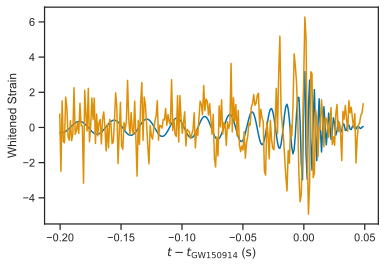

In [26]:
plot(ts, basic_waveform(ts, 2.0, 1.5, 30.0, 0.0, 0.0, 250.0, 0.01))
plot(ts, white_strain[rng])
xlabel(r'$t-t_\mathrm{GW150914}$ ($\mathrm{s}$)')
ylabel(r'Whitened Strain')

In [27]:
data = {
    'nt': len(ts),
    'ts': ts,
    'h_obs': white_strain[rng]
}
with open('stan/phenom_model.stan', 'r') as f:
    code = f.read()
model = stan.build(program_code=code, data=data)

Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/httpstan_zxfqm9oh/model_qsspgd2o.stan', line 138, column 19: Argument 0.01 suggests there may be parameters that are not unit scale; consider rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/httpstan_zxfqm9oh/model_qsspgd2o.stan', line 16, column 29: The variable fs may not have been assigned a value before its use.


In [28]:
fit = az.from_pystan(model.sample(num_chains=4))

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (203/8000)
Sampling:   4% (302/8000)
Sampling:   5% (401/8000)
Sampling:   6% (501/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3201/8000)
Sampling:  41% (3301/8000)
Samplin

array([[<AxesSubplot:title={'center':'A100'}>,
        <AxesSubplot:title={'center':'A100'}>],
       [<AxesSubplot:title={'center':'dlnAdlnf'}>,
        <AxesSubplot:title={'center':'dlnAdlnf'}>],
       [<AxesSubplot:title={'center':'phi'}>,
        <AxesSubplot:title={'center':'phi'}>],
       [<AxesSubplot:title={'center':'tc'}>,
        <AxesSubplot:title={'center':'tc'}>],
       [<AxesSubplot:title={'center':'Mc'}>,
        <AxesSubplot:title={'center':'Mc'}>],
       [<AxesSubplot:title={'center':'max_freq'}>,
        <AxesSubplot:title={'center':'max_freq'}>],
       [<AxesSubplot:title={'center':'tau'}>,
        <AxesSubplot:title={'center':'tau'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

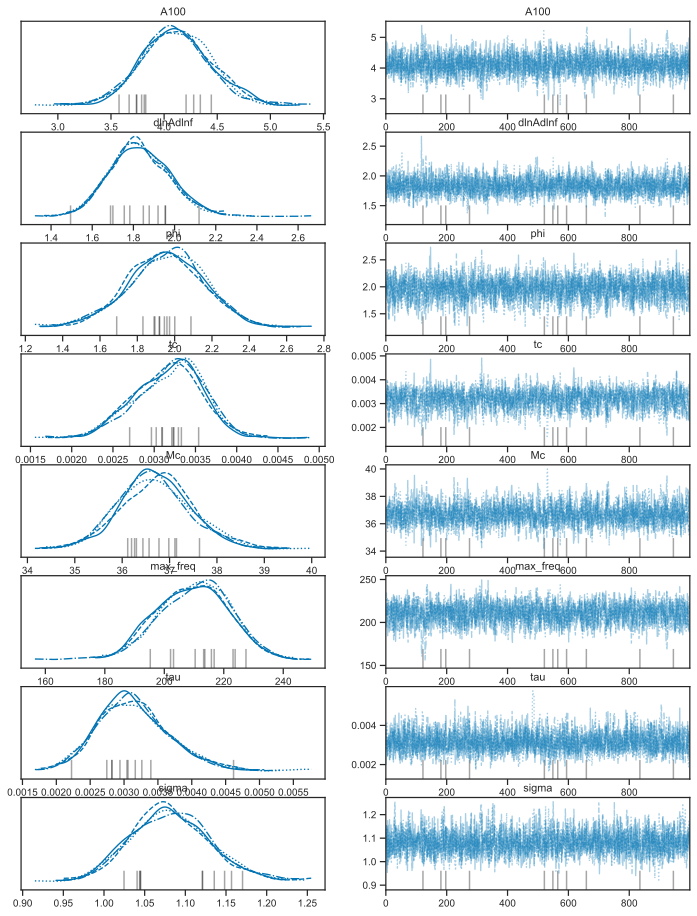

In [29]:
az.plot_trace(fit, var_names=['A100', 'dlnAdlnf', 'phi', 'tc', 'Mc', 'max_freq', 'tau', 'sigma'])

Text(0, 0.5, 'Whitened Strain')

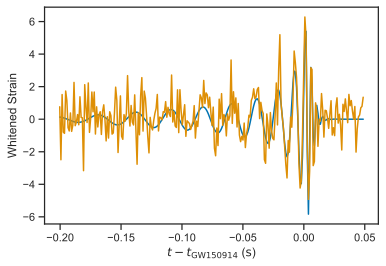

In [22]:
plot(ts, fit.posterior.h_model.mean(axis=(0,1)))
plot(ts, white_strain[rng])
xlabel(r'$t-t_\mathrm{GW150914}$ ($\mathrm{s}$)')
ylabel(r'Whitened Strain')

Note: the "real" value of $M_c$ is $\sim 30 \, M_\odot$.

<AxesSubplot:title={'center':'Mc'}>

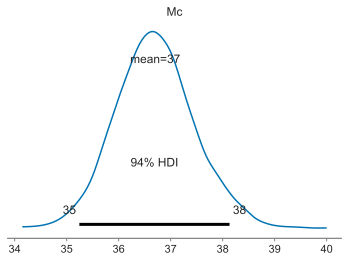

In [23]:
az.plot_posterior(fit, var_names='Mc')

## State Space Models

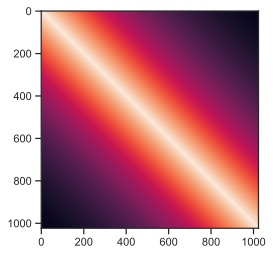

In [44]:
N = 1024
xs = linspace(-1, 1, N)

sigma2 = 10.0
tau = 1.0
def k(xi, xj):
    return sigma2*np.exp(-np.abs(xi-xj)/tau)

Sigma = zeros((N,N))
for i in range(N):
    for j in range(N):
        Sigma[i,j] = k(xs[i], xs[j])

imshow(Sigma)

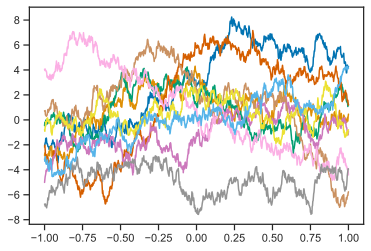

In [45]:
for i in range(10):
    plot(xs, np.random.multivariate_normal(zeros_like(xs), Sigma))

Real term corresponds to
$$
\rho(t) = a \exp\left( c t \right)
$$

$$
\frac{\mathrm{d} y}{\mathrm{d} t} + \frac{y}{\tau} = n
$$

$$
\left\langle n \right\rangle = 0
$$

$$
\left\langle n(t) n(t') \right\rangle = \sigma^2 \delta(t - t')
$$

$$
P_y(f) \sim \frac{\sigma^2 \tau}{1 + \left( 2 \pi f \tau\right)^2}
$$

$$
y(t) = y\left( t_0 \right) \exp\left( -\frac{t-t_0}{\tau} \right) + \int_0^t \mathrm{d} s \, \exp\left( -\frac{t-s}{\tau} \right) n(s)
$$

$$
\left\langle y(t) y(t') \right\rangle = \frac{\sigma^2}{\tau} \exp\left( -\frac{\left| t - t' \right|}{\tau} \right)
$$

Finite Difference analog:

$$
y_{i+1} - a y_i = n_{i+1}
$$

In [46]:
a_true = 3
c_true = 3
kernel = terms.RealTerm(a=a_true, c=c_true)
gp = celerite2.GaussianProcess(kernel)

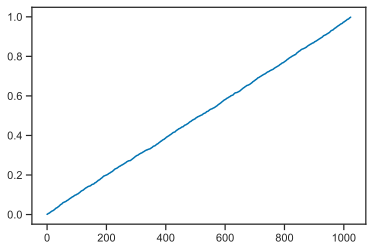

In [47]:
ts = cumsum(rand(1024))/512
plot(ts)

In [48]:
gp.compute(ts)

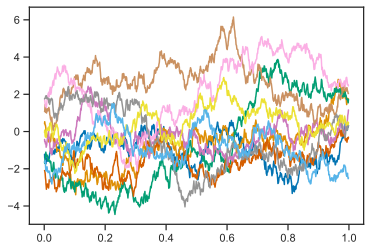

In [49]:
for _ in range(10):
    plot(ts, gp.sample())

Likelihood:
$$
p\left( \left\{ y_i \mid i = 1, \ldots N \right\} \mid a, c \right) = p\left( y_1 \mid a, c \right) \times p\left( y_2 \mid y_1, a, c \right) \times p\left( y_3 \mid y_2, y_1, a, c\right) \ldots
$$

In [50]:
ys = gp.sample()

In [51]:
with pm.Model() as celerite_model:
    a = pm.Lognormal('a', mu=log(1), sigma=1)
    c = pm.Lognormal('c', mu=log(1), sigma=1)
    
    kernel = theano_terms.RealTerm(a=a, c=c)
    gp = celerite2.theano.GaussianProcess(kernel)
    gp.compute(ts)
    _ = gp.marginal('likelihood', observed=ys)

In [52]:
with celerite_model:
    trace = pmx.sample()

ERROR (theano.graph.opt): Optimization failure due to: local_join_empty
ERROR (theano.graph.opt): node: Join(TensorConstant{0}, Elemwise{exp,no_inplace}.0, TensorConstant{[]}, TensorConstant{[]})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/theano/graph/opt.py", line 2017, in process_node
    replacements = lopt.transform(fgraph, node)
  File "/Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/theano/graph/opt.py", line 1209, in transform
    return self.fn(*args, **kwargs)
  File "/Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/theano/tensor/opt.py", line 4181, in local_join_empty
    ret = tt.patternbroadcast(ret, node.outputs[0].broadcastable)
  File "/Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/theano/tensor/basic.py", line 4181, in patternbroadcast
    return thea

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 29 seconds.
ERROR (theano.graph.opt): Optimization failure due to: local_join_empty
ERROR (theano.graph.opt): node: Join(TensorConstant{0}, Elemwise{exp,no_inplace}.0, TensorConstant{[]}, TensorConstant{[]})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/theano/graph/opt.py", line 2017, in process_node
    replacements = lopt.transform(fgraph, node)
  File "/Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/theano/graph/opt.py", line 1209, in transform
    return self.fn(*args, **kwargs)
  File "/Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/theano/tensor/opt.py", line 4181, in local_join_empty
    ret = tt.patternbroadcast(ret, node.outputs[0].broadcastable)
  File "/Users/wfarr/miniconda3/envs/Astrostatistic

ERROR (theano.graph.opt): Optimization failure due to: local_join_empty
ERROR (theano.graph.opt): node: Join(TensorConstant{0}, Elemwise{exp,no_inplace}.0, TensorConstant{[]}, TensorConstant{[]})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/theano/graph/opt.py", line 2017, in process_node
    replacements = lopt.transform(fgraph, node)
  File "/Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/theano/graph/opt.py", line 1209, in transform
    return self.fn(*args, **kwargs)
  File "/Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/theano/tensor/opt.py", line 4181, in local_join_empty
    ret = tt.patternbroadcast(ret, node.outputs[0].broadcastable)
  File "/Users/wfarr/miniconda3/envs/Astrostatistics688/lib/python3.9/site-packages/theano/tensor/basic.py", line 4181, in patternbroadcast
    return thea

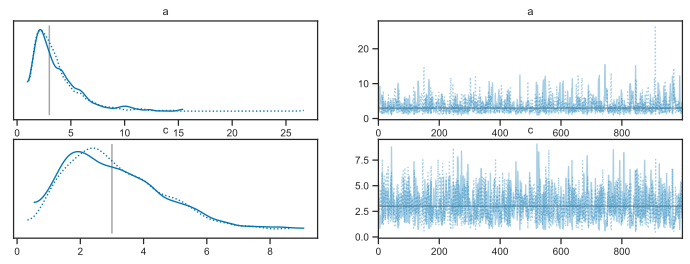

In [53]:
with celerite_model:
    pm.plot_trace(trace, lines=[('a', {}, a_true), ('c', {}, c_true)])

$$
\prod_{i=1}^p \left[ \frac{\mathrm{d}}{\mathrm{d} t} - r_i \right] y(t) = \prod_{j=1}^q \left[ \frac{\mathrm{d} }{\mathrm{d} t} - b_i \right] n(t)
$$

Recall:
$$
q < p
$$
for finite variance.

$$
P_y(f) = \sigma^2 \frac{\prod_{j=1}^q \left| \left(2\pi i f\right) - b_j \right|^2}{\prod_{i=1}^p \left| \left(2 \pi i f \right) - r_i \right|^2}
$$

$$
P_y \to \frac{1}{f^{2p - 2q}}
$$
as
$$
f \to \infty
$$

CARMA($p$, $q$)

$$
r_i = \gamma + 2\pi i f
$$

$$
Q = \frac{\pi f}{\gamma}
$$

In [55]:
omegas = [2*pi, 2*pi*sqrt(2)]
Qs = [10, 20]
variances = [1.0, 1.0]
kernel = sum([terms.SHOTerm(Q=Qs[i], sigma=sqrt(variances[i]), w0=omegas[i]) for i in range(2)])
gp = celerite2.GaussianProcess(kernel)

In [60]:
dts = 0.5*rand(1024)
ts = cumsum(dts)
gp.compute(ts)
ys = gp.sample()

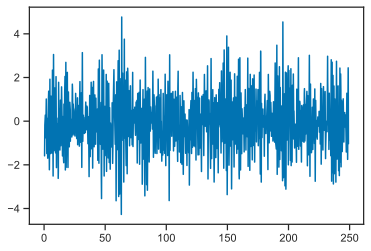

In [61]:
plot(ts, ys)

$$
p\left( y_1 \mid \vec{A}, \vec{Q}, \vec{\omega}_0 \right) \times p\left( y_2 \mid y_1, \vec{A}, \vec{Q}, \vec{\omega}_0 \right) \times p\left( y_3 \mid y_2, y_1, \vec{A}, \vec{Q}, \vec{\omega}_0 \right) \times \ldots
$$

$$
N\left[ 0, \Sigma\left(\vec{A}, \vec{Q}, \vec{\omega}_0 \right) \right]\left( y_1 \right) \times N\left[ \mu\left( t_2 \mid y_1 \right), \Sigma\left(t_2 - t_1 \mid \vec{A}, \vec{Q}, \vec{\omega}_0  \right) \right]\left( y_2 \right) \times N\left[ \mu\left( t_3 \mid y_2, y_1 \right), \Sigma\left(t_3 - t_2 \mid \vec{A}, \vec{Q}, \vec{\omega}_0  \right) \right]\left( y_3 \right) \times \ldots
$$

[Kelly, et al. (2014)](https://ui.adsabs.harvard.edu/abs/2014ApJ...788...33K/abstract) or [Foreman-Mackey, et al. (2017)](https://ui.adsabs.harvard.edu/abs/2017AJ....154..220F/abstract)

Text(0, 0.5, '$P_y(f)$')

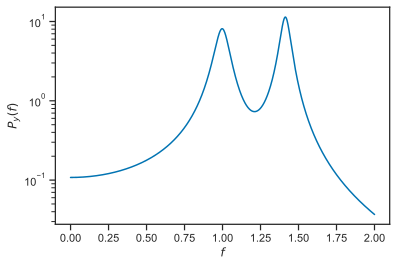

In [65]:
fs = linspace(0, 2, 1024)
plot(fs, kernel.get_psd(2*pi*fs)*2*pi)
yscale('log')
xlabel(r'$f$')
ylabel(r'$P_y(f)$')

In [ ]:
var(ys), sum(variances)

(1.9372381767218398, 2.0)

In [69]:
Nmode = 2
with pm.Model() as sho_model:
    sigmas = pm.Lognormal('sigmas', mu=log(1), sigma=1, shape=Nmode)
    fs = pm.Lognormal('fs', mu=log(1), sigma=1, shape=Nmode)
    Qs = pm.Lognormal('Qs', mu=log(10), sigma=1, shape=Nmode)
    
    gp = celerite2.theano.GaussianProcess(sum([theano_terms.SHOTerm(sigma=sigmas[i], Q=Qs[i], w0=2*pi*fs[i]) for i in range(Nmode)]))
    gp.compute(ts)
    _ = gp.marginal('likelihood', observed=ys)

In [ ]:
with sho_model:
    sho_trace = pmx.sample()

[Farr, et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018ApJ...865L..20F/abstract)